In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

In [2]:
from sklearn.cluster import AgglomerativeClustering

In [3]:
import scipy.stats
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

In [4]:
from IPython.display import HTML, display
import tabulate

ModuleNotFoundError: No module named 'tabulate'

In [5]:
df_z = pd.read_parquet('../data/pre_processed/covid_cases_z_trans.parquet')

# K-means clustering

This notebook performs k-means clustering on the cleaned and z-transformed COVID infection data. The data is accumulated, meaning that if there where 10 new cases day 1 and 2 new cases day 2, number of cases on day 2 would be 12. The dataframe loaded from pre-processing has date as index (01-03-2020 -> 17-03-2020) and country name (string) as column name as shown below.

In [6]:
df_z.head(2)

,Algeria,Argentina,Australia,Austria,Bahrain,Bangladesh,Belarus,Belgium,Bolivia,Bulgaria,...,Tunisia,Turkey,Ukraine,United Arab Emirates,United Kingdom,United States,Uruguay,Vietnam,Zambia,Zimbabwe
2020-03-01,-1.016766,-0.704723,-1.314497,-2.128248,-1.062776,-0.974537,-1.38328,-2.021154,-0.852664,-0.982762,...,-0.994483,-1.677526,-0.977963,-1.334201,-1.828760,-1.206989,-1.733456,-1.337746,-0.739615,-0.683331
2020-03-02,-1.016766,-0.704723,-1.314127,-2.127737,-1.062476,-0.974537,-1.38328,-2.020472,-0.852664,-0.982762,...,-0.994483,-1.677526,-0.977963,-1.334201,-1.828718,-1.206979,-1.733456,-1.337746,-0.739615,-0.683331


The parameters used in this notebook where selected in the notebook parameter_selection -> k_means_parameter_testing by evaluating forecasting accuracies achieved with different hyperparameter combinations (accuracies stored and compared in notebook parameter_selection -> cluster_evaluation_results).

Using sklearn KMeans package to form clusters:

In [7]:
kmeans_z = KMeans(n_clusters=4, random_state=42, init='k-means++', n_init=100, algorithm='auto').fit(df_z.T)

Array matching each country to its assigned cluster:

In [8]:
labels_kmeans_z = kmeans_z.labels_[:]
labels_kmeans_z

array([2, 2, 2, 3, 1, 1, 1, 3, 2, 2, 3, 1, 2, 2, 0, 1, 0, 3, 2, 2, 3, 2,
       3, 3, 1, 0, 0, 3, 2, 2, 1, 2, 3, 2, 2, 2, 2, 1, 3, 2, 3, 0, 2, 0,
       2, 0, 2, 3, 1, 3, 1, 1, 2, 0, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 0, 0,
       2, 0, 1, 1, 3, 3, 1, 0, 3, 2, 1, 3, 1, 1, 2, 2, 2])

Distribution of countries between clusters:

In [9]:
print("Countries in cluster 0:", np.count_nonzero(labels_kmeans_z == 0))
print("Countries in cluster 1:", np.count_nonzero(labels_kmeans_z == 1))
print("Countries in cluster 2:", np.count_nonzero(labels_kmeans_z == 2))
print("Countries in cluster 3:", np.count_nonzero(labels_kmeans_z == 3))

Countries in cluster 0: 12
Countries in cluster 1: 24
Countries in cluster 2: 30
Countries in cluster 3: 17


Creating a new dataframe for each cluster. The new formed dataframes have same format as df_z, however only the respective countries present in each cluster are included in each new dataframe. 

In [10]:
df_kmeans_z_0 = df_z.T.loc[labels_kmeans_z== 0].transpose()
df_kmeans_z_1 = df_z.T.loc[labels_kmeans_z == 1].transpose()
df_kmeans_z_2 = df_z.T.loc[labels_kmeans_z == 2].transpose()
df_kmeans_z_3 = df_z.T.loc[labels_kmeans_z == 3].transpose()

Plotting the created clusters:

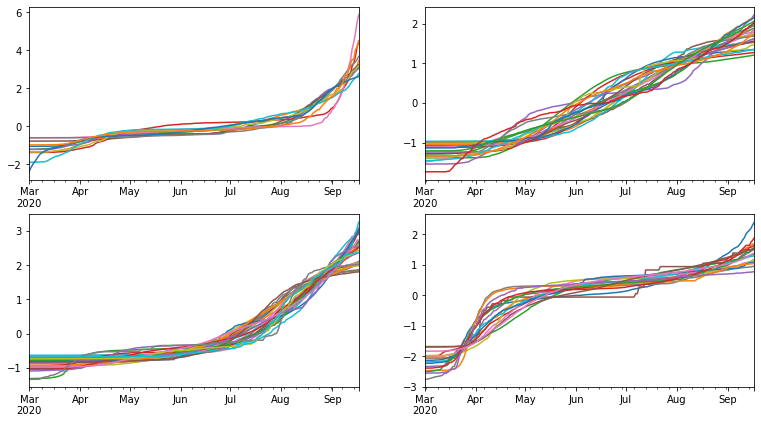

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(13, 7)
df_kmeans_z_0.plot(legend='', ax=axes[0,0])
df_kmeans_z_1.plot(legend='', ax=axes[0,1])
df_kmeans_z_2.plot(legend='', ax=axes[1,0])
df_kmeans_z_3.plot(legend='', ax=axes[1,1])

In [12]:
#HAC
hac_z = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
hac_z= hac_z.fit(df_z.T)

In [13]:
labels_hac_z = hac_z.labels_[:]
labels_hac_z

array([1, 1, 0, 0, 2, 2, 2, 3, 1, 1, 3, 2, 1, 1, 0, 0, 0, 3, 1, 1, 3, 1,
       3, 3, 2, 0, 0, 3, 1, 1, 2, 1, 3, 1, 0, 1, 1, 2, 3, 1, 3, 0, 1, 1,
       1, 0, 1, 3, 2, 3, 2, 2, 1, 1, 2, 1, 2, 2, 0, 2, 1, 2, 2, 2, 0, 0,
       1, 0, 2, 2, 3, 3, 2, 0, 3, 1, 2, 3, 2, 0, 0, 1, 1], dtype=int64)

In [14]:
df_hac_z_0 = df_z.T.loc[labels_hac_z == 0].transpose()
df_hac_z_1 = df_z.T.loc[labels_hac_z == 1].transpose()
df_hac_z_2 = df_z.T.loc[labels_hac_z == 2].transpose()
df_hac_z_3 = df_z.T.loc[labels_hac_z == 3].transpose()

In [17]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

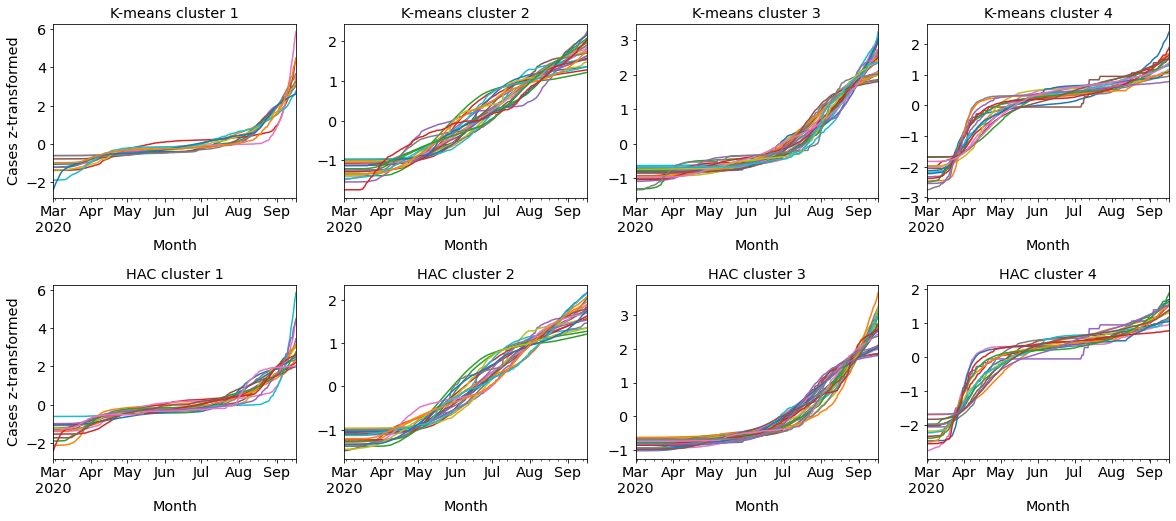

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=4)
fig.set_size_inches(20, 8)
plt.subplots_adjust(hspace=0.5)

df_kmeans_z_0.plot(legend='', ax=axes[0,0])
df_kmeans_z_1.plot(legend='', ax=axes[0,1])
df_kmeans_z_2.plot(legend='', ax=axes[0,2])
df_kmeans_z_3.plot(legend='', ax=axes[0,3])

axes[0,0].set_title('K-means cluster 1')#, fontsize=17)
axes[0,0].set(ylabel='Cases z-transformed')
axes[0,1].set_title('K-means cluster 2')#, fontsize=17)
axes[0,2].set_title('K-means cluster 3')#, fontsize=17)
axes[0,3].set_title('K-means cluster 4')#, fontsize=17)

df_hac_z_0.plot(legend='', ax=axes[1,0])
df_hac_z_2.plot(legend='', ax=axes[1,1])
df_hac_z_1.plot(legend='', ax=axes[1,2])
df_hac_z_3.plot(legend='', ax=axes[1,3])

axes[1,0].set_title('HAC cluster 1')#, fontsize=17
axes[1,0].set(ylabel='Cases z-transformed')
axes[1,1].set_title('HAC cluster 2')#, fontsize=17)
axes[1,2].set_title('HAC cluster 3')#, fontsize=17)
axes[1,3].set_title('HAC cluster 4')#, fontsize=17)



for ax in axes.flat:
    ax.set(xlabel='Month')

### Cluster score

Scoring the clusters based on three chosen metrics, see delivered paper for more information on each score. Short summarized: it is desirable to achieve a high Silhouette score, low Davies Bouldin score and a high Calinski Harabasz score.

In [16]:
table = [["Method", "Score"],
        ["Silhouette score",round(silhouette_score(df_z.T, labels=labels_kmeans_z, metric='euclidean'),4)],
        ["Davies Bouldin score",round(davies_bouldin_score(df_z.T, labels=labels_kmeans_z),4)],
        ["Calinski Harabasz score",round(calinski_harabasz_score(df_z.T, labels=labels_kmeans_z),4)]]

display(HTML(tabulate.tabulate(table, tablefmt='html')))

NameError: name 'tabulate' is not defined

#### Exporting clustering results

Cluster results are saved in parquet file. Later used in forecasting notebook forecasting -> forecasting_w_catboost_clusters

In [ ]:
#df_kmeans_z_0.to_parquet('../results/clustering_results/df_kmeans_z_0.parquet')
#df_kmeans_z_1.to_parquet('../results/clustering_results/df_kmeans_z_1.parquet')
#df_kmeans_z_2.to_parquet('../results/clustering_results/df_kmeans_z_2.parquet')
#df_kmeans_z_3.to_parquet('../results/clustering_results/df_kmeans_z_3.parquet')